In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf

%matplotlib inline
plt.style.use('ggplot')

In [2]:
def read_data(file_path):
    column_names = ['user-id','activity','timestamp', 'x-axis', 'y-axis', 'z-axis']
    data = pd.read_csv(file_path,header = None, names = column_names)
    return data

def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

In [3]:
def plot_axis(ax, x, y, title):
    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)


#create
def plot_subject(subject,data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows = 3, figsize = (15, 10), sharex = True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'x-axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'y-axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(subject)
    plt.subplots_adjust(top=0.90)
    plt.show()
    
    
def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += (size / 2)

def segment_signal(data,window_size = 90):
    segments = np.empty((0,window_size,3))
    labels = np.empty((0))
    for (start, end) in windows(data['timestamp'], window_size):
        x = data["x-axis"][start:end]
        y = data["y-axis"][start:end]
        z = data["z-axis"][start:end]
        if(len(dataset['timestamp'][start:end]) == window_size):
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels = np.append(labels,stats.mode(data["user-id"][start:end])[0][0])
    return segments, labels

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.0, shape = shape)
    return tf.Variable(initial)

def depthwise_conv2d(x, W):
    return tf.nn.depthwise_conv2d(x,W, [1, 1, 1, 1], padding='VALID')

def apply_depthwise_conv(x,kernel_size,num_channels,depth):
    weights = weight_variable([1, kernel_size, num_channels, depth])
    biases = bias_variable([depth * num_channels])
    return tf.nn.relu(tf.add(depthwise_conv2d(x, weights),biases))
    
def apply_max_pool(x,kernel_size,stride_size):
    return tf.nn.max_pool(x, ksize=[1, 1, kernel_size, 1], 
                          strides=[1, 1, stride_size, 1], padding='VALID')

In [4]:
dataset = read_data('actitracker_raw2.txt')
dataset = dataset.replace(";","",regex=True)#.replace(';',',')

In [5]:
dataset['x-axis'] = feature_normalize(dataset['x-axis'])
dataset['y-axis'] = feature_normalize(dataset['y-axis'])
dataset['z-axis'] = feature_normalize(dataset['z-axis'])

TypeError: must be str, not int

In [6]:
dataset

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.198203,0.804142,0.50395286
1,33,Jogging,49106062271000,0.635039,0.594170,0.95342433
2,33,Jogging,49106112167000,0.619130,0.537639,-0.08172209
3,33,Jogging,49106222305000,-0.186271,1.666240,3.0237172
4,33,Jogging,49106332290000,-0.269795,0.719346,7.205164
5,33,Jogging,49106442306000,0.104071,-1.444986,-6.510526
6,33,Jogging,49106542312000,-0.186271,0.491202,5.706926
7,33,Jogging,49106652389000,-0.170362,0.991906,7.0553403
8,33,Jogging,49106762313000,-1.327754,0.616378,5.134871
9,33,Jogging,49106872299000,0.042423,-0.871599,1.6480621


TypeError: unsupported operand type(s) for -: 'float' and 'str'

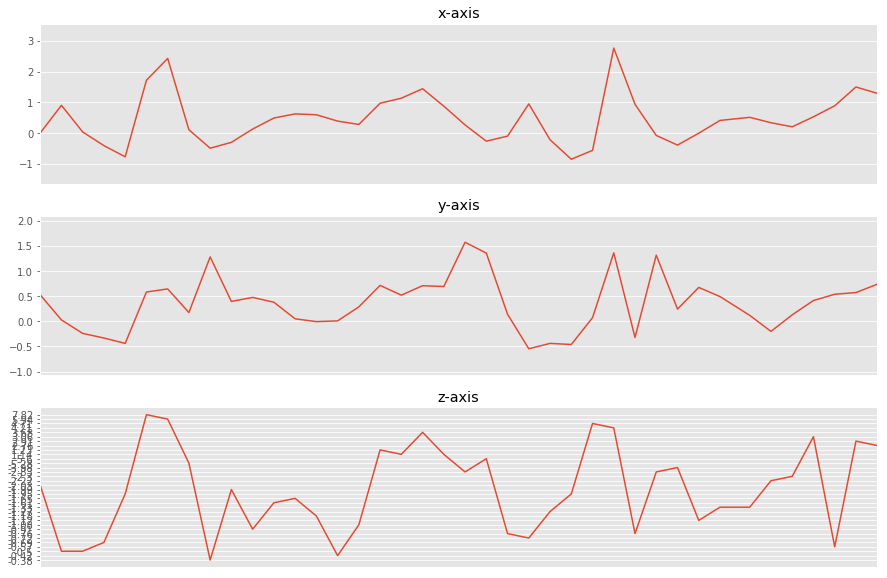

In [7]:
#modify taerget(user-id)
for subject in np.unique(dataset["user-id"]):
    subset = dataset[dataset["user-id"] == subject][:40]
    plot_subject(subject,subset)

In [8]:
segments, labels = segment_signal(dataset)
labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
reshaped_segments = segments.reshape(len(segments), 1,90, 3)

In [9]:
train_test_split = np.random.rand(len(reshaped_segments)) < 0.70

train_x = reshaped_segments[train_test_split]
train_y = labels[train_test_split]
test_x = reshaped_segments[~train_test_split]
test_y = labels[~train_test_split]

In [1]:
#saved data
np.save('train_x.npy',train_x)
np.save('train_y.npy',train_y)
np.save('test_x.npy',test_x)
np.save('test_y.npy',test_y)

NameError: name 'np' is not defined

In [4]:
import numpy as np
train_x = np.load('train_x.npy')
train_y = np.load('train_y.npy')
test_x = np.load('test_x.npy')
test_y = np.load('test_y.npy')

In [5]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 300

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            merged = tf.summary.merge_all()
            writer = tf.summary.FileWriter('./logs', session.graph)
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  88.5429  Training Accuracy:  0.0408583
Epoch:  1  Training Loss:  84.0675  Training Accuracy:  0.0412111
Epoch:  2  Training Loss:  79.2168  Training Accuracy:  0.0443269
Epoch:  3  Training Loss:  75.8388  Training Accuracy:  0.0513228
Epoch:  4  Training Loss:  73.3623  Training Accuracy:  0.0567901
Epoch:  5  Training Loss:  71.4037  Training Accuracy:  0.0624927
Epoch:  6  Training Loss:  69.4983  Training Accuracy:  0.0652557
Epoch:  7  Training Loss:  67.7493  Training Accuracy:  0.068254
Epoch:  8  Training Loss:  65.8863  Training Accuracy:  0.0714874
Epoch:  9  Training Loss:  64.1148  Training Accuracy:  0.0745444
Epoch:  10  Training Loss:  62.3745  Training Accuracy:  0.0787184
Epoch:  11  Training Loss:  60.9252  Training Accuracy:  0.0843621
Epoch:  12  Training Loss:  59.6367  Training Accuracy:  0.0906526
Epoch:  13  Training Loss:  58.4354  Training Accuracy:  0.0975309
Epoch:  14  Training Loss:  57.272  Training Accuracy:  0.105291
Epoch:  

Epoch:  125  Training Loss:  3.03307  Training Accuracy:  0.498413
Epoch:  126  Training Loss:  2.96266  Training Accuracy:  0.500353
Epoch:  127  Training Loss:  2.89437  Training Accuracy:  0.501881
Epoch:  128  Training Loss:  2.82923  Training Accuracy:  0.503998
Epoch:  129  Training Loss:  2.76539  Training Accuracy:  0.50582
Epoch:  130  Training Loss:  2.70614  Training Accuracy:  0.507407
Epoch:  131  Training Loss:  2.6497  Training Accuracy:  0.5097
Epoch:  132  Training Loss:  2.59534  Training Accuracy:  0.511934
Epoch:  133  Training Loss:  2.5427  Training Accuracy:  0.513874
Epoch:  134  Training Loss:  2.49206  Training Accuracy:  0.516167
Epoch:  135  Training Loss:  2.44423  Training Accuracy:  0.517931
Epoch:  136  Training Loss:  2.39724  Training Accuracy:  0.520106
Epoch:  137  Training Loss:  2.35184  Training Accuracy:  0.521399
Epoch:  138  Training Loss:  2.30872  Training Accuracy:  0.523045
Epoch:  139  Training Loss:  2.26542  Training Accuracy:  0.52428
E

Epoch:  248  Training Loss:  1.03657  Training Accuracy:  0.683186
Epoch:  249  Training Loss:  1.03207  Training Accuracy:  0.68448
Epoch:  250  Training Loss:  1.02813  Training Accuracy:  0.686126
Epoch:  251  Training Loss:  1.02339  Training Accuracy:  0.687478
Epoch:  252  Training Loss:  1.01863  Training Accuracy:  0.688889
Epoch:  253  Training Loss:  1.01395  Training Accuracy:  0.690124
Epoch:  254  Training Loss:  1.00943  Training Accuracy:  0.691123
Epoch:  255  Training Loss:  1.00522  Training Accuracy:  0.691828
Epoch:  256  Training Loss:  1.00046  Training Accuracy:  0.692828
Epoch:  257  Training Loss:  0.995941  Training Accuracy:  0.694356
Epoch:  258  Training Loss:  0.991043  Training Accuracy:  0.695826
Epoch:  259  Training Loss:  0.986677  Training Accuracy:  0.696943
Epoch:  260  Training Loss:  0.981976  Training Accuracy:  0.698648
Epoch:  261  Training Loss:  0.97736  Training Accuracy:  0.699706
Epoch:  262  Training Loss:  0.972673  Training Accuracy:  

In [7]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 500

total_batches = train_x.shape[0] // batch_size

X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [8]:
with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  94.7185  Training Accuracy:  0.0409171
Epoch:  1  Training Loss:  89.7656  Training Accuracy:  0.0409759
Epoch:  2  Training Loss:  86.1089  Training Accuracy:  0.0412698
Epoch:  3  Training Loss:  82.8551  Training Accuracy:  0.0453263
Epoch:  4  Training Loss:  80.3039  Training Accuracy:  0.048736
Epoch:  5  Training Loss:  78.0848  Training Accuracy:  0.0512052
Epoch:  6  Training Loss:  76.2207  Training Accuracy:  0.0557319
Epoch:  7  Training Loss:  74.4234  Training Accuracy:  0.0597296
Epoch:  8  Training Loss:  72.8387  Training Accuracy:  0.0638448
Epoch:  9  Training Loss:  71.2813  Training Accuracy:  0.0693122
Epoch:  10  Training Loss:  69.8515  Training Accuracy:  0.0742504
Epoch:  11  Training Loss:  68.554  Training Accuracy:  0.0800705
Epoch:  12  Training Loss:  67.3346  Training Accuracy:  0.0854791
Epoch:  13  Training Loss:  66.1287  Training Accuracy:  0.0914168
Epoch:  14  Training Loss:  65.0155  Training Accuracy:  0.097766
Epoch:  

Epoch:  125  Training Loss:  3.28099  Training Accuracy:  0.499765
Epoch:  126  Training Loss:  3.20701  Training Accuracy:  0.501176
Epoch:  127  Training Loss:  3.13561  Training Accuracy:  0.502881
Epoch:  128  Training Loss:  3.06874  Training Accuracy:  0.50435
Epoch:  129  Training Loss:  3.00505  Training Accuracy:  0.505996
Epoch:  130  Training Loss:  2.94202  Training Accuracy:  0.508465
Epoch:  131  Training Loss:  2.88199  Training Accuracy:  0.510347
Epoch:  132  Training Loss:  2.8237  Training Accuracy:  0.511993
Epoch:  133  Training Loss:  2.76567  Training Accuracy:  0.513815
Epoch:  134  Training Loss:  2.70935  Training Accuracy:  0.515109
Epoch:  135  Training Loss:  2.65338  Training Accuracy:  0.517401
Epoch:  136  Training Loss:  2.6015  Training Accuracy:  0.519283
Epoch:  137  Training Loss:  2.5503  Training Accuracy:  0.52134
Epoch:  138  Training Loss:  2.50351  Training Accuracy:  0.52281
Epoch:  139  Training Loss:  2.457  Training Accuracy:  0.524515
Epo

Epoch:  248  Training Loss:  0.662955  Training Accuracy:  0.688536
Epoch:  249  Training Loss:  0.657779  Training Accuracy:  0.689771
Epoch:  250  Training Loss:  0.652206  Training Accuracy:  0.691182
Epoch:  251  Training Loss:  0.647171  Training Accuracy:  0.692064
Epoch:  252  Training Loss:  0.642601  Training Accuracy:  0.693298
Epoch:  253  Training Loss:  0.6379  Training Accuracy:  0.694709
Epoch:  254  Training Loss:  0.633172  Training Accuracy:  0.696296
Epoch:  255  Training Loss:  0.629059  Training Accuracy:  0.697531
Epoch:  256  Training Loss:  0.62469  Training Accuracy:  0.698824
Epoch:  257  Training Loss:  0.620309  Training Accuracy:  0.700412
Epoch:  258  Training Loss:  0.615856  Training Accuracy:  0.701294
Epoch:  259  Training Loss:  0.611411  Training Accuracy:  0.702175
Epoch:  260  Training Loss:  0.60747  Training Accuracy:  0.703292
Epoch:  261  Training Loss:  0.6033  Training Accuracy:  0.704351
Epoch:  262  Training Loss:  0.600098  Training Accura

Epoch:  369  Training Loss:  0.366189  Training Accuracy:  0.808348
Epoch:  370  Training Loss:  0.365107  Training Accuracy:  0.809465
Epoch:  371  Training Loss:  0.363867  Training Accuracy:  0.810171
Epoch:  372  Training Loss:  0.362743  Training Accuracy:  0.810935
Epoch:  373  Training Loss:  0.361527  Training Accuracy:  0.811405
Epoch:  374  Training Loss:  0.360505  Training Accuracy:  0.811934
Epoch:  375  Training Loss:  0.359184  Training Accuracy:  0.812875
Epoch:  376  Training Loss:  0.358032  Training Accuracy:  0.813992
Epoch:  377  Training Loss:  0.357164  Training Accuracy:  0.814874
Epoch:  378  Training Loss:  0.356154  Training Accuracy:  0.815462
Epoch:  379  Training Loss:  0.355029  Training Accuracy:  0.816579
Epoch:  380  Training Loss:  0.35416  Training Accuracy:  0.817284
Epoch:  381  Training Loss:  0.353123  Training Accuracy:  0.81799
Epoch:  382  Training Loss:  0.35217  Training Accuracy:  0.818695
Epoch:  383  Training Loss:  0.351185  Training Acc

Epoch:  490  Training Loss:  0.265198  Training Accuracy:  0.872487
Epoch:  491  Training Loss:  0.264323  Training Accuracy:  0.872663
Epoch:  492  Training Loss:  0.263636  Training Accuracy:  0.873251
Epoch:  493  Training Loss:  0.262735  Training Accuracy:  0.873604
Epoch:  494  Training Loss:  0.262173  Training Accuracy:  0.873722
Epoch:  495  Training Loss:  0.261363  Training Accuracy:  0.873957
Epoch:  496  Training Loss:  0.260503  Training Accuracy:  0.874133
Epoch:  497  Training Loss:  0.259938  Training Accuracy:  0.874251
Epoch:  498  Training Loss:  0.259101  Training Accuracy:  0.874604
Epoch:  499  Training Loss:  0.258635  Training Accuracy:  0.874897
Testing Accuracy: 0.802787


In [9]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 700

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  77.3511  Training Accuracy:  0.0393886
Epoch:  1  Training Loss:  80.1859  Training Accuracy:  0.0402116
Epoch:  2  Training Loss:  74.5507  Training Accuracy:  0.0409759
Epoch:  3  Training Loss:  70.0906  Training Accuracy:  0.041505
Epoch:  4  Training Loss:  66.1622  Training Accuracy:  0.0432099
Epoch:  5  Training Loss:  63.0256  Training Accuracy:  0.0457378
Epoch:  6  Training Loss:  60.3409  Training Accuracy:  0.0497942
Epoch:  7  Training Loss:  57.8776  Training Accuracy:  0.0553792
Epoch:  8  Training Loss:  55.6271  Training Accuracy:  0.0600823
Epoch:  9  Training Loss:  53.4911  Training Accuracy:  0.0642563
Epoch:  10  Training Loss:  51.5495  Training Accuracy:  0.0690182
Epoch:  11  Training Loss:  49.8849  Training Accuracy:  0.0743092
Epoch:  12  Training Loss:  48.4075  Training Accuracy:  0.0817754
Epoch:  13  Training Loss:  46.9097  Training Accuracy:  0.087184
Epoch:  14  Training Loss:  45.5748  Training Accuracy:  0.0926514
Epoch: 

Epoch:  125  Training Loss:  4.00456  Training Accuracy:  0.4893
Epoch:  126  Training Loss:  3.93707  Training Accuracy:  0.491475
Epoch:  127  Training Loss:  3.874  Training Accuracy:  0.493474
Epoch:  128  Training Loss:  3.81678  Training Accuracy:  0.495591
Epoch:  129  Training Loss:  3.761  Training Accuracy:  0.497531
Epoch:  130  Training Loss:  3.70569  Training Accuracy:  0.499824
Epoch:  131  Training Loss:  3.6541  Training Accuracy:  0.501881
Epoch:  132  Training Loss:  3.60016  Training Accuracy:  0.504233
Epoch:  133  Training Loss:  3.5447  Training Accuracy:  0.507407
Epoch:  134  Training Loss:  3.49512  Training Accuracy:  0.510582
Epoch:  135  Training Loss:  3.44495  Training Accuracy:  0.513051
Epoch:  136  Training Loss:  3.39378  Training Accuracy:  0.515814
Epoch:  137  Training Loss:  3.34366  Training Accuracy:  0.518636
Epoch:  138  Training Loss:  3.29414  Training Accuracy:  0.520694
Epoch:  139  Training Loss:  3.24592  Training Accuracy:  0.523633
Epo

Epoch:  248  Training Loss:  0.908852  Training Accuracy:  0.691005
Epoch:  249  Training Loss:  0.899504  Training Accuracy:  0.691887
Epoch:  250  Training Loss:  0.890899  Training Accuracy:  0.692828
Epoch:  251  Training Loss:  0.881958  Training Accuracy:  0.693945
Epoch:  252  Training Loss:  0.872906  Training Accuracy:  0.694827
Epoch:  253  Training Loss:  0.863356  Training Accuracy:  0.695826
Epoch:  254  Training Loss:  0.854771  Training Accuracy:  0.697061
Epoch:  255  Training Loss:  0.845001  Training Accuracy:  0.69806
Epoch:  256  Training Loss:  0.836813  Training Accuracy:  0.699001
Epoch:  257  Training Loss:  0.828233  Training Accuracy:  0.700059
Epoch:  258  Training Loss:  0.819964  Training Accuracy:  0.701235
Epoch:  259  Training Loss:  0.811445  Training Accuracy:  0.702411
Epoch:  260  Training Loss:  0.803123  Training Accuracy:  0.70388
Epoch:  261  Training Loss:  0.795302  Training Accuracy:  0.704997
Epoch:  262  Training Loss:  0.787593  Training Ac

Epoch:  369  Training Loss:  0.34422  Training Accuracy:  0.800471
Epoch:  370  Training Loss:  0.342125  Training Accuracy:  0.801176
Epoch:  371  Training Loss:  0.339892  Training Accuracy:  0.801705
Epoch:  372  Training Loss:  0.337611  Training Accuracy:  0.802293
Epoch:  373  Training Loss:  0.33561  Training Accuracy:  0.80294
Epoch:  374  Training Loss:  0.333539  Training Accuracy:  0.803704
Epoch:  375  Training Loss:  0.331504  Training Accuracy:  0.804351
Epoch:  376  Training Loss:  0.32936  Training Accuracy:  0.805115
Epoch:  377  Training Loss:  0.327201  Training Accuracy:  0.805762
Epoch:  378  Training Loss:  0.325002  Training Accuracy:  0.806349
Epoch:  379  Training Loss:  0.323177  Training Accuracy:  0.807408
Epoch:  380  Training Loss:  0.321089  Training Accuracy:  0.807819
Epoch:  381  Training Loss:  0.318774  Training Accuracy:  0.808642
Epoch:  382  Training Loss:  0.316691  Training Accuracy:  0.809348
Epoch:  383  Training Loss:  0.31461  Training Accur

Epoch:  490  Training Loss:  0.190449  Training Accuracy:  0.867137
Epoch:  491  Training Loss:  0.189377  Training Accuracy:  0.867373
Epoch:  492  Training Loss:  0.188254  Training Accuracy:  0.867667
Epoch:  493  Training Loss:  0.187301  Training Accuracy:  0.868137
Epoch:  494  Training Loss:  0.186498  Training Accuracy:  0.868607
Epoch:  495  Training Loss:  0.185484  Training Accuracy:  0.868783
Epoch:  496  Training Loss:  0.184634  Training Accuracy:  0.869077
Epoch:  497  Training Loss:  0.183672  Training Accuracy:  0.869606
Epoch:  498  Training Loss:  0.182821  Training Accuracy:  0.869842
Epoch:  499  Training Loss:  0.182007  Training Accuracy:  0.870312
Epoch:  500  Training Loss:  0.181399  Training Accuracy:  0.870606
Epoch:  501  Training Loss:  0.180699  Training Accuracy:  0.871076
Epoch:  502  Training Loss:  0.180197  Training Accuracy:  0.871311
Epoch:  503  Training Loss:  0.179707  Training Accuracy:  0.871429
Epoch:  504  Training Loss:  0.179144  Training 

Epoch:  611  Training Loss:  0.139407  Training Accuracy:  0.906232
Epoch:  612  Training Loss:  0.139136  Training Accuracy:  0.906526
Epoch:  613  Training Loss:  0.13907  Training Accuracy:  0.906879
Epoch:  614  Training Loss:  0.138763  Training Accuracy:  0.907055
Epoch:  615  Training Loss:  0.138666  Training Accuracy:  0.907349
Epoch:  616  Training Loss:  0.138443  Training Accuracy:  0.907643
Epoch:  617  Training Loss:  0.13834  Training Accuracy:  0.908055
Epoch:  618  Training Loss:  0.138064  Training Accuracy:  0.908878
Epoch:  619  Training Loss:  0.137936  Training Accuracy:  0.909172
Epoch:  620  Training Loss:  0.137752  Training Accuracy:  0.909524
Epoch:  621  Training Loss:  0.137662  Training Accuracy:  0.910112
Epoch:  622  Training Loss:  0.137331  Training Accuracy:  0.910524
Epoch:  623  Training Loss:  0.137156  Training Accuracy:  0.910582
Epoch:  624  Training Loss:  0.136936  Training Accuracy:  0.910935
Epoch:  625  Training Loss:  0.136744  Training Ac

In [10]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size =10
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 700

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
#optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  111.776  Training Accuracy:  0.040682
Epoch:  1  Training Loss:  103.429  Training Accuracy:  0.0409171
Epoch:  2  Training Loss:  97.7269  Training Accuracy:  0.0417402
Epoch:  3  Training Loss:  92.9377  Training Accuracy:  0.0458554
Epoch:  4  Training Loss:  88.5904  Training Accuracy:  0.0480306
Epoch:  5  Training Loss:  84.5804  Training Accuracy:  0.0510288
Epoch:  6  Training Loss:  81.0006  Training Accuracy:  0.0535567
Epoch:  7  Training Loss:  77.8068  Training Accuracy:  0.0560259
Epoch:  8  Training Loss:  74.7887  Training Accuracy:  0.0594944
Epoch:  9  Training Loss:  71.8854  Training Accuracy:  0.06408
Epoch:  10  Training Loss:  69.1493  Training Accuracy:  0.0701352
Epoch:  11  Training Loss:  66.5967  Training Accuracy:  0.0758965
Epoch:  12  Training Loss:  64.0846  Training Accuracy:  0.0815403
Epoch:  13  Training Loss:  61.7395  Training Accuracy:  0.0890065
Epoch:  14  Training Loss:  59.6304  Training Accuracy:  0.0961199
Epoch:  

Epoch:  125  Training Loss:  2.0076  Training Accuracy:  0.485361
Epoch:  126  Training Loss:  1.95159  Training Accuracy:  0.487478
Epoch:  127  Training Loss:  1.89598  Training Accuracy:  0.489124
Epoch:  128  Training Loss:  1.84414  Training Accuracy:  0.490358
Epoch:  129  Training Loss:  1.79353  Training Accuracy:  0.492299
Epoch:  130  Training Loss:  1.74617  Training Accuracy:  0.494533
Epoch:  131  Training Loss:  1.69989  Training Accuracy:  0.496179
Epoch:  132  Training Loss:  1.6561  Training Accuracy:  0.497883
Epoch:  133  Training Loss:  1.61484  Training Accuracy:  0.499824
Epoch:  134  Training Loss:  1.5742  Training Accuracy:  0.502175
Epoch:  135  Training Loss:  1.54224  Training Accuracy:  0.503586
Epoch:  136  Training Loss:  1.51077  Training Accuracy:  0.50582
Epoch:  137  Training Loss:  1.48073  Training Accuracy:  0.507995
Epoch:  138  Training Loss:  1.4517  Training Accuracy:  0.50923
Epoch:  139  Training Loss:  1.4243  Training Accuracy:  0.51117
Epo

Epoch:  247  Training Loss:  0.457332  Training Accuracy:  0.680952
Epoch:  248  Training Loss:  0.453658  Training Accuracy:  0.682187
Epoch:  249  Training Loss:  0.450299  Training Accuracy:  0.683245
Epoch:  250  Training Loss:  0.446972  Training Accuracy:  0.684362
Epoch:  251  Training Loss:  0.443608  Training Accuracy:  0.685538
Epoch:  252  Training Loss:  0.440405  Training Accuracy:  0.687302
Epoch:  253  Training Loss:  0.437225  Training Accuracy:  0.688713
Epoch:  254  Training Loss:  0.434004  Training Accuracy:  0.689947
Epoch:  255  Training Loss:  0.430412  Training Accuracy:  0.690947
Epoch:  256  Training Loss:  0.426952  Training Accuracy:  0.692299
Epoch:  257  Training Loss:  0.423443  Training Accuracy:  0.693357
Epoch:  258  Training Loss:  0.419812  Training Accuracy:  0.694592
Epoch:  259  Training Loss:  0.416219  Training Accuracy:  0.695944
Epoch:  260  Training Loss:  0.412923  Training Accuracy:  0.697355
Epoch:  261  Training Loss:  0.409491  Training 

Epoch:  368  Training Loss:  0.186742  Training Accuracy:  0.803822
Epoch:  369  Training Loss:  0.185633  Training Accuracy:  0.804351
Epoch:  370  Training Loss:  0.184453  Training Accuracy:  0.805174
Epoch:  371  Training Loss:  0.183369  Training Accuracy:  0.805703
Epoch:  372  Training Loss:  0.182163  Training Accuracy:  0.806291
Epoch:  373  Training Loss:  0.181108  Training Accuracy:  0.806937
Epoch:  374  Training Loss:  0.180058  Training Accuracy:  0.807466
Epoch:  375  Training Loss:  0.178947  Training Accuracy:  0.808113
Epoch:  376  Training Loss:  0.177888  Training Accuracy:  0.808995
Epoch:  377  Training Loss:  0.176795  Training Accuracy:  0.810053
Epoch:  378  Training Loss:  0.175669  Training Accuracy:  0.810935
Epoch:  379  Training Loss:  0.174584  Training Accuracy:  0.811464
Epoch:  380  Training Loss:  0.173443  Training Accuracy:  0.811993
Epoch:  381  Training Loss:  0.172495  Training Accuracy:  0.812464
Epoch:  382  Training Loss:  0.171366  Training 

Epoch:  489  Training Loss:  0.111093  Training Accuracy:  0.874427
Epoch:  490  Training Loss:  0.110746  Training Accuracy:  0.874839
Epoch:  491  Training Loss:  0.110433  Training Accuracy:  0.875309
Epoch:  492  Training Loss:  0.110047  Training Accuracy:  0.875603
Epoch:  493  Training Loss:  0.109701  Training Accuracy:  0.875956
Epoch:  494  Training Loss:  0.109399  Training Accuracy:  0.876367
Epoch:  495  Training Loss:  0.109099  Training Accuracy:  0.87719
Epoch:  496  Training Loss:  0.108813  Training Accuracy:  0.877308
Epoch:  497  Training Loss:  0.108495  Training Accuracy:  0.877719
Epoch:  498  Training Loss:  0.108188  Training Accuracy:  0.878072
Epoch:  499  Training Loss:  0.107849  Training Accuracy:  0.878484
Epoch:  500  Training Loss:  0.107534  Training Accuracy:  0.878836
Epoch:  501  Training Loss:  0.107281  Training Accuracy:  0.879424
Epoch:  502  Training Loss:  0.106922  Training Accuracy:  0.879542
Epoch:  503  Training Loss:  0.106675  Training A

Epoch:  609  Training Loss:  0.0999368  Training Accuracy:  0.912699
Epoch:  610  Training Loss:  0.100054  Training Accuracy:  0.912875
Epoch:  611  Training Loss:  0.100124  Training Accuracy:  0.913228
Epoch:  612  Training Loss:  0.1002  Training Accuracy:  0.913581
Epoch:  613  Training Loss:  0.100311  Training Accuracy:  0.913816
Epoch:  614  Training Loss:  0.10037  Training Accuracy:  0.914051
Epoch:  615  Training Loss:  0.100502  Training Accuracy:  0.914345
Epoch:  616  Training Loss:  0.10059  Training Accuracy:  0.914756
Epoch:  617  Training Loss:  0.100694  Training Accuracy:  0.914933
Epoch:  618  Training Loss:  0.100742  Training Accuracy:  0.914992
Epoch:  619  Training Loss:  0.100871  Training Accuracy:  0.915227
Epoch:  620  Training Loss:  0.100939  Training Accuracy:  0.915344
Epoch:  621  Training Loss:  0.100907  Training Accuracy:  0.91558
Epoch:  622  Training Loss:  0.101027  Training Accuracy:  0.915697
Epoch:  623  Training Loss:  0.101042  Training Accu

In [11]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 1000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  158.753  Training Accuracy:  0.0444444
Epoch:  1  Training Loss:  102.651  Training Accuracy:  0.0409759
Epoch:  2  Training Loss:  95.6677  Training Accuracy:  0.0465021
Epoch:  3  Training Loss:  90.5245  Training Accuracy:  0.0519106
Epoch:  4  Training Loss:  86.3577  Training Accuracy:  0.0579071
Epoch:  5  Training Loss:  82.9014  Training Accuracy:  0.0634333
Epoch:  6  Training Loss:  80.1226  Training Accuracy:  0.068254
Epoch:  7  Training Loss:  77.752  Training Accuracy:  0.0722516
Epoch:  8  Training Loss:  75.4969  Training Accuracy:  0.0763081
Epoch:  9  Training Loss:  73.4069  Training Accuracy:  0.0820106
Epoch:  10  Training Loss:  71.4874  Training Accuracy:  0.0878895
Epoch:  11  Training Loss:  69.8364  Training Accuracy:  0.0928865
Epoch:  12  Training Loss:  68.2586  Training Accuracy:  0.0998824
Epoch:  13  Training Loss:  66.728  Training Accuracy:  0.108054
Epoch:  14  Training Loss:  65.2463  Training Accuracy:  0.114815
Epoch:  15

Epoch:  125  Training Loss:  3.16783  Training Accuracy:  0.499706
Epoch:  126  Training Loss:  3.11132  Training Accuracy:  0.501705
Epoch:  127  Training Loss:  3.05832  Training Accuracy:  0.504174
Epoch:  128  Training Loss:  3.0064  Training Accuracy:  0.505996
Epoch:  129  Training Loss:  2.9574  Training Accuracy:  0.508113
Epoch:  130  Training Loss:  2.90929  Training Accuracy:  0.51017
Epoch:  131  Training Loss:  2.86426  Training Accuracy:  0.511875
Epoch:  132  Training Loss:  2.82144  Training Accuracy:  0.512698
Epoch:  133  Training Loss:  2.78002  Training Accuracy:  0.514815
Epoch:  134  Training Loss:  2.73944  Training Accuracy:  0.516578
Epoch:  135  Training Loss:  2.69919  Training Accuracy:  0.518166
Epoch:  136  Training Loss:  2.66044  Training Accuracy:  0.520223
Epoch:  137  Training Loss:  2.62288  Training Accuracy:  0.522457
Epoch:  138  Training Loss:  2.58743  Training Accuracy:  0.52475
Epoch:  139  Training Loss:  2.55204  Training Accuracy:  0.526514

Epoch:  248  Training Loss:  0.900521  Training Accuracy:  0.688007
Epoch:  249  Training Loss:  0.892703  Training Accuracy:  0.689418
Epoch:  250  Training Loss:  0.885262  Training Accuracy:  0.690535
Epoch:  251  Training Loss:  0.877591  Training Accuracy:  0.69177
Epoch:  252  Training Loss:  0.870547  Training Accuracy:  0.693063
Epoch:  253  Training Loss:  0.863198  Training Accuracy:  0.694121
Epoch:  254  Training Loss:  0.855844  Training Accuracy:  0.695415
Epoch:  255  Training Loss:  0.848337  Training Accuracy:  0.696649
Epoch:  256  Training Loss:  0.841759  Training Accuracy:  0.697296
Epoch:  257  Training Loss:  0.834826  Training Accuracy:  0.69853
Epoch:  258  Training Loss:  0.827897  Training Accuracy:  0.699824
Epoch:  259  Training Loss:  0.820956  Training Accuracy:  0.700529
Epoch:  260  Training Loss:  0.814424  Training Accuracy:  0.701764
Epoch:  261  Training Loss:  0.807743  Training Accuracy:  0.702587
Epoch:  262  Training Loss:  0.801378  Training Ac

Epoch:  369  Training Loss:  0.381874  Training Accuracy:  0.807172
Epoch:  370  Training Loss:  0.380192  Training Accuracy:  0.808172
Epoch:  371  Training Loss:  0.378404  Training Accuracy:  0.809583
Epoch:  372  Training Loss:  0.376813  Training Accuracy:  0.810465
Epoch:  373  Training Loss:  0.375072  Training Accuracy:  0.811347
Epoch:  374  Training Loss:  0.373035  Training Accuracy:  0.812346
Epoch:  375  Training Loss:  0.371186  Training Accuracy:  0.813404
Epoch:  376  Training Loss:  0.369104  Training Accuracy:  0.81411
Epoch:  377  Training Loss:  0.367368  Training Accuracy:  0.814933
Epoch:  378  Training Loss:  0.365624  Training Accuracy:  0.815697
Epoch:  379  Training Loss:  0.364102  Training Accuracy:  0.816755
Epoch:  380  Training Loss:  0.362489  Training Accuracy:  0.817519
Epoch:  381  Training Loss:  0.360873  Training Accuracy:  0.818225
Epoch:  382  Training Loss:  0.358945  Training Accuracy:  0.818989
Epoch:  383  Training Loss:  0.356996  Training A

Epoch:  490  Training Loss:  0.244251  Training Accuracy:  0.872135
Epoch:  491  Training Loss:  0.243602  Training Accuracy:  0.872487
Epoch:  492  Training Loss:  0.243005  Training Accuracy:  0.872664
Epoch:  493  Training Loss:  0.242395  Training Accuracy:  0.872899
Epoch:  494  Training Loss:  0.241724  Training Accuracy:  0.873016
Epoch:  495  Training Loss:  0.24124  Training Accuracy:  0.873075
Epoch:  496  Training Loss:  0.240708  Training Accuracy:  0.873134
Epoch:  497  Training Loss:  0.240025  Training Accuracy:  0.873545
Epoch:  498  Training Loss:  0.239426  Training Accuracy:  0.874016
Epoch:  499  Training Loss:  0.238979  Training Accuracy:  0.87431
Epoch:  500  Training Loss:  0.23843  Training Accuracy:  0.874604
Epoch:  501  Training Loss:  0.237795  Training Accuracy:  0.874898
Epoch:  502  Training Loss:  0.237283  Training Accuracy:  0.875074
Epoch:  503  Training Loss:  0.236506  Training Accuracy:  0.875368
Epoch:  504  Training Loss:  0.235954  Training Acc

Epoch:  611  Training Loss:  0.158948  Training Accuracy:  0.907349
Epoch:  612  Training Loss:  0.158287  Training Accuracy:  0.907584
Epoch:  613  Training Loss:  0.157426  Training Accuracy:  0.907819
Epoch:  614  Training Loss:  0.156877  Training Accuracy:  0.908231
Epoch:  615  Training Loss:  0.156204  Training Accuracy:  0.908349
Epoch:  616  Training Loss:  0.155406  Training Accuracy:  0.908466
Epoch:  617  Training Loss:  0.15487  Training Accuracy:  0.908642
Epoch:  618  Training Loss:  0.154284  Training Accuracy:  0.908995
Epoch:  619  Training Loss:  0.153538  Training Accuracy:  0.909172
Epoch:  620  Training Loss:  0.152892  Training Accuracy:  0.909407
Epoch:  621  Training Loss:  0.152122  Training Accuracy:  0.909759
Epoch:  622  Training Loss:  0.151506  Training Accuracy:  0.910406
Epoch:  623  Training Loss:  0.150845  Training Accuracy:  0.910406
Epoch:  624  Training Loss:  0.150081  Training Accuracy:  0.910818
Epoch:  625  Training Loss:  0.149482  Training A

Epoch:  732  Training Loss:  0.102157  Training Accuracy:  0.932452
Epoch:  733  Training Loss:  0.101808  Training Accuracy:  0.93257
Epoch:  734  Training Loss:  0.101531  Training Accuracy:  0.932746
Epoch:  735  Training Loss:  0.101248  Training Accuracy:  0.932922
Epoch:  736  Training Loss:  0.100957  Training Accuracy:  0.933393
Epoch:  737  Training Loss:  0.100616  Training Accuracy:  0.93351
Epoch:  738  Training Loss:  0.100401  Training Accuracy:  0.933569
Epoch:  739  Training Loss:  0.100154  Training Accuracy:  0.933687
Epoch:  740  Training Loss:  0.099823  Training Accuracy:  0.933804
Epoch:  741  Training Loss:  0.0995704  Training Accuracy:  0.933981
Epoch:  742  Training Loss:  0.0993773  Training Accuracy:  0.934216
Epoch:  743  Training Loss:  0.0990575  Training Accuracy:  0.934451
Epoch:  744  Training Loss:  0.0988466  Training Accuracy:  0.934568
Epoch:  745  Training Loss:  0.0985969  Training Accuracy:  0.934627
Epoch:  746  Training Loss:  0.0983203  Train

Epoch:  852  Training Loss:  0.071065  Training Accuracy:  0.951206
Epoch:  853  Training Loss:  0.0708172  Training Accuracy:  0.951382
Epoch:  854  Training Loss:  0.0704973  Training Accuracy:  0.951441
Epoch:  855  Training Loss:  0.0702616  Training Accuracy:  0.951558
Epoch:  856  Training Loss:  0.0700319  Training Accuracy:  0.951676
Epoch:  857  Training Loss:  0.069778  Training Accuracy:  0.951911
Epoch:  858  Training Loss:  0.0695703  Training Accuracy:  0.95197
Epoch:  859  Training Loss:  0.0693326  Training Accuracy:  0.952029
Epoch:  860  Training Loss:  0.0690999  Training Accuracy:  0.952264
Epoch:  861  Training Loss:  0.0687975  Training Accuracy:  0.95244
Epoch:  862  Training Loss:  0.0685885  Training Accuracy:  0.952499
Epoch:  863  Training Loss:  0.0683863  Training Accuracy:  0.952675
Epoch:  864  Training Loss:  0.0681565  Training Accuracy:  0.952852
Epoch:  865  Training Loss:  0.067971  Training Accuracy:  0.952852
Epoch:  866  Training Loss:  0.0677377 

Epoch:  972  Training Loss:  0.0485201  Training Accuracy:  0.96214
Epoch:  973  Training Loss:  0.0484223  Training Accuracy:  0.96214
Epoch:  974  Training Loss:  0.0483054  Training Accuracy:  0.96214
Epoch:  975  Training Loss:  0.0481564  Training Accuracy:  0.962258
Epoch:  976  Training Loss:  0.0480272  Training Accuracy:  0.962317
Epoch:  977  Training Loss:  0.047902  Training Accuracy:  0.962317
Epoch:  978  Training Loss:  0.0477786  Training Accuracy:  0.962434
Epoch:  979  Training Loss:  0.0476614  Training Accuracy:  0.962493
Epoch:  980  Training Loss:  0.0475516  Training Accuracy:  0.962787
Epoch:  981  Training Loss:  0.047396  Training Accuracy:  0.962846
Epoch:  982  Training Loss:  0.0472948  Training Accuracy:  0.962846
Epoch:  983  Training Loss:  0.0471668  Training Accuracy:  0.962964
Epoch:  984  Training Loss:  0.047058  Training Accuracy:  0.963022
Epoch:  985  Training Loss:  0.0468955  Training Accuracy:  0.96314
Epoch:  986  Training Loss:  0.0468117  T

In [6]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 100

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)


correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  132.002  Training Accuracy:  0.0409171
Epoch:  1  Training Loss:  128.139  Training Accuracy:  0.0409171
Epoch:  2  Training Loss:  124.723  Training Accuracy:  0.042328
Epoch:  3  Training Loss:  113.589  Training Accuracy:  0.0490888
Epoch:  4  Training Loss:  104.427  Training Accuracy:  0.0556731
Epoch:  5  Training Loss:  97.9281  Training Accuracy:  0.0599647
Epoch:  6  Training Loss:  93.119  Training Accuracy:  0.0643739
Epoch:  7  Training Loss:  89.3246  Training Accuracy:  0.067137
Epoch:  8  Training Loss:  86.2618  Training Accuracy:  0.0712522
Epoch:  9  Training Loss:  83.5915  Training Accuracy:  0.0743092
Epoch:  10  Training Loss:  81.1141  Training Accuracy:  0.076602
Epoch:  11  Training Loss:  78.6606  Training Accuracy:  0.0803057
Epoch:  12  Training Loss:  76.076  Training Accuracy:  0.0848325
Epoch:  13  Training Loss:  73.2805  Training Accuracy:  0.0895356
Epoch:  14  Training Loss:  70.3549  Training Accuracy:  0.0948266
Epoch:  15

In [12]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 300

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  151.741  Training Accuracy:  0.0401529
Epoch:  1  Training Loss:  152.047  Training Accuracy:  0.0409171
Epoch:  2  Training Loss:  145.162  Training Accuracy:  0.040682
Epoch:  3  Training Loss:  133.363  Training Accuracy:  0.0447972
Epoch:  4  Training Loss:  123.018  Training Accuracy:  0.0473251
Epoch:  5  Training Loss:  114.525  Training Accuracy:  0.0508524
Epoch:  6  Training Loss:  107.671  Training Accuracy:  0.0553792
Epoch:  7  Training Loss:  101.787  Training Accuracy:  0.0607878
Epoch:  8  Training Loss:  96.6536  Training Accuracy:  0.06602
Epoch:  9  Training Loss:  92.0948  Training Accuracy:  0.0726043
Epoch:  10  Training Loss:  87.8935  Training Accuracy:  0.0781893
Epoch:  11  Training Loss:  83.8237  Training Accuracy:  0.0845973
Epoch:  12  Training Loss:  79.6005  Training Accuracy:  0.0914756
Epoch:  13  Training Loss:  75.2286  Training Accuracy:  0.0986478
Epoch:  14  Training Loss:  70.7869  Training Accuracy:  0.106643
Epoch:  1

Epoch:  125  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  126  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  127  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  128  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  129  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  130  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  131  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  132  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  133  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  134  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  135  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  136  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  137  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  138  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  139  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  140  Training Loss:  nan  Traini

Epoch:  254  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  255  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  256  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  257  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  258  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  259  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  260  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  261  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  262  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  263  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  264  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  265  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  266  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  267  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  268  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  269  Training Loss:  nan  Traini

In [15]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 400

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  139.178  Training Accuracy:  0.0409171
Epoch:  1  Training Loss:  131.4  Training Accuracy:  0.0409171
Epoch:  2  Training Loss:  126.248  Training Accuracy:  0.0409759
Epoch:  3  Training Loss:  112.831  Training Accuracy:  0.045679
Epoch:  4  Training Loss:  102.25  Training Accuracy:  0.0492651
Epoch:  5  Training Loss:  94.4986  Training Accuracy:  0.0559083
Epoch:  6  Training Loss:  89.0949  Training Accuracy:  0.061552
Epoch:  7  Training Loss:  85.0535  Training Accuracy:  0.0677249
Epoch:  8  Training Loss:  81.7987  Training Accuracy:  0.0714286
Epoch:  9  Training Loss:  79.0284  Training Accuracy:  0.0751911
Epoch:  10  Training Loss:  76.5063  Training Accuracy:  0.080776
Epoch:  11  Training Loss:  74.0989  Training Accuracy:  0.0864198
Epoch:  12  Training Loss:  71.6682  Training Accuracy:  0.0944738
Epoch:  13  Training Loss:  69.1208  Training Accuracy:  0.102058
Epoch:  14  Training Loss:  66.5328  Training Accuracy:  0.109171
Epoch:  15  T

Epoch:  126  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  127  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  128  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  129  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  130  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  131  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  132  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  133  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  134  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  135  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  136  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  137  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  138  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  139  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  140  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  141  Training Loss:  nan  Traini

Epoch:  255  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  256  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  257  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  258  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  259  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  260  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  261  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  262  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  263  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  264  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  265  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  266  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  267  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  268  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  269  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  270  Training Loss:  nan  Traini

Epoch:  384  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  385  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  386  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  387  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  388  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  389  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  390  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  391  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  392  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  393  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  394  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  395  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  396  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  397  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  398  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  399  Training Loss:  nan  Traini

In [16]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 500

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  151.081  Training Accuracy:  0.0409171
Epoch:  1  Training Loss:  134.595  Training Accuracy:  0.0410935
Epoch:  2  Training Loss:  125.717  Training Accuracy:  0.0455026
Epoch:  3  Training Loss:  112.681  Training Accuracy:  0.0514991
Epoch:  4  Training Loss:  101.946  Training Accuracy:  0.0566725
Epoch:  5  Training Loss:  94.3619  Training Accuracy:  0.060435
Epoch:  6  Training Loss:  88.8311  Training Accuracy:  0.0656672
Epoch:  7  Training Loss:  84.7768  Training Accuracy:  0.0701352
Epoch:  8  Training Loss:  81.6118  Training Accuracy:  0.0759553
Epoch:  9  Training Loss:  78.9645  Training Accuracy:  0.0801293
Epoch:  10  Training Loss:  76.4036  Training Accuracy:  0.0843033
Epoch:  11  Training Loss:  73.7895  Training Accuracy:  0.0891828
Epoch:  12  Training Loss:  70.9536  Training Accuracy:  0.0937684
Epoch:  13  Training Loss:  67.83  Training Accuracy:  0.0985891
Epoch:  14  Training Loss:  64.5351  Training Accuracy:  0.105703
Epoch:  1

Epoch:  124  Training Loss:  0.829112  Training Accuracy:  0.544621
Epoch:  125  Training Loss:  0.815811  Training Accuracy:  0.546443
Epoch:  126  Training Loss:  0.802988  Training Accuracy:  0.547795
Epoch:  127  Training Loss:  0.789127  Training Accuracy:  0.54856
Epoch:  128  Training Loss:  0.78542  Training Accuracy:  0.549559
Epoch:  129  Training Loss:  0.774797  Training Accuracy:  0.550147
Epoch:  130  Training Loss:  0.778799  Training Accuracy:  0.550911
Epoch:  131  Training Loss:  0.77433  Training Accuracy:  0.551675
Epoch:  132  Training Loss:  0.749025  Training Accuracy:  0.552969
Epoch:  133  Training Loss:  0.745318  Training Accuracy:  0.553909
Epoch:  134  Training Loss:  0.728149  Training Accuracy:  0.554968
Epoch:  135  Training Loss:  0.716109  Training Accuracy:  0.556555
Epoch:  136  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  137  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  138  Training Loss:  nan  Training Accuracy:  0.026

Epoch:  252  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  253  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  254  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  255  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  256  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  257  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  258  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  259  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  260  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  261  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  262  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  263  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  264  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  265  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  266  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  267  Training Loss:  nan  Traini

Epoch:  381  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  382  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  383  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  384  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  385  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  386  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  387  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  388  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  389  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  390  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  391  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  392  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  393  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  394  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  395  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  396  Training Loss:  nan  Traini

In [17]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 600

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  124.676  Training Accuracy:  0.0409171
Epoch:  1  Training Loss:  112.47  Training Accuracy:  0.0409171
Epoch:  2  Training Loss:  105.829  Training Accuracy:  0.0446208
Epoch:  3  Training Loss:  97.546  Training Accuracy:  0.0507349
Epoch:  4  Training Loss:  90.6015  Training Accuracy:  0.0559083
Epoch:  5  Training Loss:  85.3153  Training Accuracy:  0.060435
Epoch:  6  Training Loss:  81.4132  Training Accuracy:  0.0636684
Epoch:  7  Training Loss:  78.4299  Training Accuracy:  0.0662551
Epoch:  8  Training Loss:  75.9824  Training Accuracy:  0.0698413
Epoch:  9  Training Loss:  73.8974  Training Accuracy:  0.0738389
Epoch:  10  Training Loss:  72.1534  Training Accuracy:  0.0800705
Epoch:  11  Training Loss:  70.5575  Training Accuracy:  0.0848912
Epoch:  12  Training Loss:  68.9934  Training Accuracy:  0.0898295
Epoch:  13  Training Loss:  67.3526  Training Accuracy:  0.0962375
Epoch:  14  Training Loss:  65.6532  Training Accuracy:  0.102528
Epoch:  1

Epoch:  125  Training Loss:  2.42248  Training Accuracy:  0.536978
Epoch:  126  Training Loss:  2.3612  Training Accuracy:  0.538389
Epoch:  127  Training Loss:  2.28188  Training Accuracy:  0.539095
Epoch:  128  Training Loss:  2.23469  Training Accuracy:  0.540799
Epoch:  129  Training Loss:  2.19192  Training Accuracy:  0.541916
Epoch:  130  Training Loss:  2.14033  Training Accuracy:  0.543386
Epoch:  131  Training Loss:  2.11167  Training Accuracy:  0.544327
Epoch:  132  Training Loss:  2.07378  Training Accuracy:  0.545561
Epoch:  133  Training Loss:  2.04454  Training Accuracy:  0.54709
Epoch:  134  Training Loss:  1.99189  Training Accuracy:  0.548618
Epoch:  135  Training Loss:  1.96143  Training Accuracy:  0.549853
Epoch:  136  Training Loss:  1.89669  Training Accuracy:  0.550617
Epoch:  137  Training Loss:  1.88048  Training Accuracy:  0.552322
Epoch:  138  Training Loss:  1.83541  Training Accuracy:  0.553204
Epoch:  139  Training Loss:  1.81003  Training Accuracy:  0.5546

Epoch:  253  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  254  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  255  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  256  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  257  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  258  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  259  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  260  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  261  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  262  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  263  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  264  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  265  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  266  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  267  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  268  Training Loss:  nan  Traini

Epoch:  382  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  383  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  384  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  385  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  386  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  387  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  388  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  389  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  390  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  391  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  392  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  393  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  394  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  395  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  396  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  397  Training Loss:  nan  Traini

Epoch:  511  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  512  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  513  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  514  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  515  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  516  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  517  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  518  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  519  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  520  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  521  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  522  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  523  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  524  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  525  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  526  Training Loss:  nan  Traini

In [18]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 10
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 1000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  175.615  Training Accuracy:  0.0409171
Epoch:  1  Training Loss:  141.838  Training Accuracy:  0.0409171
Epoch:  2  Training Loss:  127.823  Training Accuracy:  0.0462669
Epoch:  3  Training Loss:  114.735  Training Accuracy:  0.0530864
Epoch:  4  Training Loss:  104.378  Training Accuracy:  0.0582011
Epoch:  5  Training Loss:  97.0706  Training Accuracy:  0.0634921
Epoch:  6  Training Loss:  92.1192  Training Accuracy:  0.0680188
Epoch:  7  Training Loss:  88.3668  Training Accuracy:  0.0730747
Epoch:  8  Training Loss:  85.2273  Training Accuracy:  0.0769547
Epoch:  9  Training Loss:  82.4338  Training Accuracy:  0.0814815
Epoch:  10  Training Loss:  79.7954  Training Accuracy:  0.0877131
Epoch:  11  Training Loss:  77.2156  Training Accuracy:  0.0943563
Epoch:  12  Training Loss:  74.5958  Training Accuracy:  0.101529
Epoch:  13  Training Loss:  71.8586  Training Accuracy:  0.109347
Epoch:  14  Training Loss:  69.0806  Training Accuracy:  0.118812
Epoch:  

Epoch:  125  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  126  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  127  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  128  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  129  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  130  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  131  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  132  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  133  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  134  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  135  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  136  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  137  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  138  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  139  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  140  Training Loss:  nan  Traini

Epoch:  254  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  255  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  256  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  257  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  258  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  259  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  260  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  261  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  262  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  263  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  264  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  265  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  266  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  267  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  268  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  269  Training Loss:  nan  Traini

Epoch:  383  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  384  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  385  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  386  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  387  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  388  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  389  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  390  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  391  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  392  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  393  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  394  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  395  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  396  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  397  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  398  Training Loss:  nan  Traini

Epoch:  512  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  513  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  514  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  515  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  516  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  517  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  518  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  519  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  520  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  521  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  522  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  523  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  524  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  525  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  526  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  527  Training Loss:  nan  Traini

Epoch:  641  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  642  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  643  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  644  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  645  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  646  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  647  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  648  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  649  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  650  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  651  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  652  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  653  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  654  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  655  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  656  Training Loss:  nan  Traini

Epoch:  770  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  771  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  772  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  773  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  774  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  775  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  776  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  777  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  778  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  779  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  780  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  781  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  782  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  783  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  784  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  785  Training Loss:  nan  Traini

Epoch:  899  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  900  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  901  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  902  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  903  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  904  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  905  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  906  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  907  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  908  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  909  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  910  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  911  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  912  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  913  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  914  Training Loss:  nan  Traini

In [19]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 5
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 1000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  65.4361  Training Accuracy:  0.0450911
Epoch:  1  Training Loss:  74.5786  Training Accuracy:  0.0451499
Epoch:  2  Training Loss:  77.3696  Training Accuracy:  0.0477954
Epoch:  3  Training Loss:  74.0615  Training Accuracy:  0.0507936
Epoch:  4  Training Loss:  68.255  Training Accuracy:  0.0548501
Epoch:  5  Training Loss:  62.7934  Training Accuracy:  0.0579659
Epoch:  6  Training Loss:  58.4304  Training Accuracy:  0.0627278
Epoch:  7  Training Loss:  54.8783  Training Accuracy:  0.0687831
Epoch:  8  Training Loss:  51.2769  Training Accuracy:  0.074368
Epoch:  9  Training Loss:  47.7494  Training Accuracy:  0.0802469
Epoch:  10  Training Loss:  44.4792  Training Accuracy:  0.0900059
Epoch:  11  Training Loss:  41.376  Training Accuracy:  0.0987066
Epoch:  12  Training Loss:  38.5132  Training Accuracy:  0.107525
Epoch:  13  Training Loss:  35.9985  Training Accuracy:  0.115344
Epoch:  14  Training Loss:  33.8671  Training Accuracy:  0.124809
Epoch:  15 

Epoch:  129  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  130  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  131  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  132  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  133  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  134  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  135  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  136  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  137  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  138  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  139  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  140  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  141  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  142  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  143  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  144  Training Loss:  nan  Traini

Epoch:  258  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  259  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  260  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  261  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  262  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  263  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  264  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  265  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  266  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  267  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  268  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  269  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  270  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  271  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  272  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  273  Training Loss:  nan  Traini

Epoch:  387  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  388  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  389  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  390  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  391  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  392  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  393  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  394  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  395  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  396  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  397  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  398  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  399  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  400  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  401  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  402  Training Loss:  nan  Traini

Epoch:  516  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  517  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  518  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  519  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  520  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  521  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  522  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  523  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  524  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  525  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  526  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  527  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  528  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  529  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  530  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  531  Training Loss:  nan  Traini

Epoch:  645  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  646  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  647  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  648  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  649  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  650  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  651  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  652  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  653  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  654  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  655  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  656  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  657  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  658  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  659  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  660  Training Loss:  nan  Traini

Epoch:  774  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  775  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  776  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  777  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  778  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  779  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  780  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  781  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  782  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  783  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  784  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  785  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  786  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  787  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  788  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  789  Training Loss:  nan  Traini

Epoch:  903  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  904  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  905  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  906  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  907  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  908  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  909  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  910  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  911  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  912  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  913  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  914  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  915  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  916  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  917  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  918  Training Loss:  nan  Traini

In [20]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 5
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-4
training_epochs = 1000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
#optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  69.7262  Training Accuracy:  0.0409171
Epoch:  1  Training Loss:  66.9482  Training Accuracy:  0.041505
Epoch:  2  Training Loss:  61.5993  Training Accuracy:  0.0451499
Epoch:  3  Training Loss:  56.999  Training Accuracy:  0.0503821
Epoch:  4  Training Loss:  52.7865  Training Accuracy:  0.0557319
Epoch:  5  Training Loss:  48.522  Training Accuracy:  0.0599647
Epoch:  6  Training Loss:  44.2681  Training Accuracy:  0.0644327
Epoch:  7  Training Loss:  39.8075  Training Accuracy:  0.0712522
Epoch:  8  Training Loss:  35.6324  Training Accuracy:  0.0789536
Epoch:  9  Training Loss:  31.7614  Training Accuracy:  0.0838918
Epoch:  10  Training Loss:  28.2217  Training Accuracy:  0.0897707
Epoch:  11  Training Loss:  25.0965  Training Accuracy:  0.0946502
Epoch:  12  Training Loss:  22.2333  Training Accuracy:  0.0981775
Epoch:  13  Training Loss:  19.8218  Training Accuracy:  0.100764
Epoch:  14  Training Loss:  17.7094  Training Accuracy:  0.103233
Epoch:  15

Epoch:  123  Training Loss:  0.0316841  Training Accuracy:  0.481364
Epoch:  124  Training Loss:  0.0306716  Training Accuracy:  0.483539
Epoch:  125  Training Loss:  0.0297519  Training Accuracy:  0.486537
Epoch:  126  Training Loss:  0.0290915  Training Accuracy:  0.488301
Epoch:  127  Training Loss:  0.0279839  Training Accuracy:  0.491417
Epoch:  128  Training Loss:  0.0270411  Training Accuracy:  0.494415
Epoch:  129  Training Loss:  0.0262986  Training Accuracy:  0.497296
Epoch:  130  Training Loss:  0.0252793  Training Accuracy:  0.499294
Epoch:  131  Training Loss:  0.0242238  Training Accuracy:  0.501528
Epoch:  132  Training Loss:  0.0233571  Training Accuracy:  0.503998
Epoch:  133  Training Loss:  0.0223578  Training Accuracy:  0.506055
Epoch:  134  Training Loss:  0.0215175  Training Accuracy:  0.509289
Epoch:  135  Training Loss:  0.0206517  Training Accuracy:  0.512757
Epoch:  136  Training Loss:  0.019764  Training Accuracy:  0.515755
Epoch:  137  Training Loss:  0.0191

Epoch:  248  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  249  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  250  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  251  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  252  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  253  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  254  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  255  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  256  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  257  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  258  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  259  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  260  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  261  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  262  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  263  Training Loss:  nan  Traini

Epoch:  377  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  378  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  379  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  380  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  381  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  382  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  383  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  384  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  385  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  386  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  387  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  388  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  389  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  390  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  391  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  392  Training Loss:  nan  Traini

Epoch:  506  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  507  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  508  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  509  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  510  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  511  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  512  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  513  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  514  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  515  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  516  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  517  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  518  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  519  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  520  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  521  Training Loss:  nan  Traini

Epoch:  635  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  636  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  637  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  638  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  639  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  640  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  641  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  642  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  643  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  644  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  645  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  646  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  647  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  648  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  649  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  650  Training Loss:  nan  Traini

Epoch:  764  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  765  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  766  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  767  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  768  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  769  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  770  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  771  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  772  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  773  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  774  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  775  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  776  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  777  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  778  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  779  Training Loss:  nan  Traini

Epoch:  893  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  894  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  895  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  896  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  897  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  898  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  899  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  900  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  901  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  902  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  903  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  904  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  905  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  906  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  907  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  908  Training Loss:  nan  Traini

In [21]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 32
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 1000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  113.665  Training Accuracy:  0.0717813
Epoch:  1  Training Loss:  66.5284  Training Accuracy:  0.0503233
Epoch:  2  Training Loss:  70.4829  Training Accuracy:  0.0620223
Epoch:  3  Training Loss:  72.4087  Training Accuracy:  0.0699001
Epoch:  4  Training Loss:  73.4326  Training Accuracy:  0.0784245
Epoch:  5  Training Loss:  73.7902  Training Accuracy:  0.0862434
Epoch:  6  Training Loss:  73.6133  Training Accuracy:  0.0972957
Epoch:  7  Training Loss:  73.0214  Training Accuracy:  0.104468
Epoch:  8  Training Loss:  72.08  Training Accuracy:  0.109289
Epoch:  9  Training Loss:  70.9796  Training Accuracy:  0.114815
Epoch:  10  Training Loss:  69.6447  Training Accuracy:  0.120635
Epoch:  11  Training Loss:  68.193  Training Accuracy:  0.127866
Epoch:  12  Training Loss:  66.6143  Training Accuracy:  0.13545
Epoch:  13  Training Loss:  64.9021  Training Accuracy:  0.14221
Epoch:  14  Training Loss:  63.1572  Training Accuracy:  0.148854
Epoch:  15  Traini

Epoch:  125  Training Loss:  53.1867  Training Accuracy:  0.576426
Epoch:  126  Training Loss:  53.2513  Training Accuracy:  0.578483
Epoch:  127  Training Loss:  53.4364  Training Accuracy:  0.579483
Epoch:  128  Training Loss:  53.5102  Training Accuracy:  0.580952
Epoch:  129  Training Loss:  53.6514  Training Accuracy:  0.583186
Epoch:  130  Training Loss:  53.7368  Training Accuracy:  0.585185
Epoch:  131  Training Loss:  53.8742  Training Accuracy:  0.588007
Epoch:  132  Training Loss:  53.9278  Training Accuracy:  0.58983
Epoch:  133  Training Loss:  54.1115  Training Accuracy:  0.591534
Epoch:  134  Training Loss:  54.1501  Training Accuracy:  0.593357
Epoch:  135  Training Loss:  54.2919  Training Accuracy:  0.594768
Epoch:  136  Training Loss:  54.3606  Training Accuracy:  0.596414
Epoch:  137  Training Loss:  54.5238  Training Accuracy:  0.59853
Epoch:  138  Training Loss:  54.6116  Training Accuracy:  0.599882
Epoch:  139  Training Loss:  54.6699  Training Accuracy:  0.6014

Epoch:  248  Training Loss:  60.0481  Training Accuracy:  0.724045
Epoch:  249  Training Loss:  60.038  Training Accuracy:  0.724633
Epoch:  250  Training Loss:  60.0794  Training Accuracy:  0.725573
Epoch:  251  Training Loss:  60.1391  Training Accuracy:  0.726749
Epoch:  252  Training Loss:  60.1612  Training Accuracy:  0.728337
Epoch:  253  Training Loss:  60.1166  Training Accuracy:  0.729453
Epoch:  254  Training Loss:  60.1867  Training Accuracy:  0.730218
Epoch:  255  Training Loss:  60.1858  Training Accuracy:  0.731041
Epoch:  256  Training Loss:  60.2171  Training Accuracy:  0.731805
Epoch:  257  Training Loss:  60.2451  Training Accuracy:  0.732687
Epoch:  258  Training Loss:  60.2626  Training Accuracy:  0.733627
Epoch:  259  Training Loss:  60.2416  Training Accuracy:  0.734215
Epoch:  260  Training Loss:  60.3025  Training Accuracy:  0.734509
Epoch:  261  Training Loss:  60.3008  Training Accuracy:  0.735685
Epoch:  262  Training Loss:  60.3454  Training Accuracy:  0.736

Epoch:  371  Training Loss:  61.5304  Training Accuracy:  0.800647
Epoch:  372  Training Loss:  61.5548  Training Accuracy:  0.801235
Epoch:  373  Training Loss:  61.5657  Training Accuracy:  0.801999
Epoch:  374  Training Loss:  61.5564  Training Accuracy:  0.802352
Epoch:  375  Training Loss:  61.5373  Training Accuracy:  0.802999
Epoch:  376  Training Loss:  61.5564  Training Accuracy:  0.803586
Epoch:  377  Training Loss:  61.5779  Training Accuracy:  0.804645
Epoch:  378  Training Loss:  61.6266  Training Accuracy:  0.805233
Epoch:  379  Training Loss:  61.5388  Training Accuracy:  0.805879
Epoch:  380  Training Loss:  61.5871  Training Accuracy:  0.806056
Epoch:  381  Training Loss:  61.545  Training Accuracy:  0.806585
Epoch:  382  Training Loss:  61.5559  Training Accuracy:  0.807055
Epoch:  383  Training Loss:  61.595  Training Accuracy:  0.807231
Epoch:  384  Training Loss:  61.543  Training Accuracy:  0.807819
Epoch:  385  Training Loss:  61.5262  Training Accuracy:  0.80864

Epoch:  494  Training Loss:  60.3745  Training Accuracy:  0.860142
Epoch:  495  Training Loss:  60.3641  Training Accuracy:  0.860671
Epoch:  496  Training Loss:  60.3937  Training Accuracy:  0.8612
Epoch:  497  Training Loss:  60.3861  Training Accuracy:  0.861611
Epoch:  498  Training Loss:  60.3791  Training Accuracy:  0.861788
Epoch:  499  Training Loss:  60.3267  Training Accuracy:  0.862199
Epoch:  500  Training Loss:  60.3876  Training Accuracy:  0.862846
Epoch:  501  Training Loss:  60.3723  Training Accuracy:  0.863434
Epoch:  502  Training Loss:  60.3899  Training Accuracy:  0.863963
Epoch:  503  Training Loss:  60.3477  Training Accuracy:  0.864257
Epoch:  504  Training Loss:  60.3225  Training Accuracy:  0.865197
Epoch:  505  Training Loss:  60.3666  Training Accuracy:  0.865433
Epoch:  506  Training Loss:  60.4021  Training Accuracy:  0.86602
Epoch:  507  Training Loss:  60.3366  Training Accuracy:  0.866138
Epoch:  508  Training Loss:  60.3545  Training Accuracy:  0.86655

Epoch:  620  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  621  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  622  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  623  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  624  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  625  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  626  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  627  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  628  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  629  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  630  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  631  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  632  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  633  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  634  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  635  Training Loss:  nan  Traini

Epoch:  749  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  750  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  751  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  752  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  753  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  754  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  755  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  756  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  757  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  758  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  759  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  760  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  761  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  762  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  763  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  764  Training Loss:  nan  Traini

Epoch:  878  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  879  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  880  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  881  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  882  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  883  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  884  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  885  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  886  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  887  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  888  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  889  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  890  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  891  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  892  Training Loss:  nan  Training Accuracy:  0.0266314
Epoch:  893  Training Loss:  nan  Traini

In [22]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 32
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 1000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
#optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  104.313  Training Accuracy:  0.0436802
Epoch:  1  Training Loss:  88.487  Training Accuracy:  0.047913
Epoch:  2  Training Loss:  76.1234  Training Accuracy:  0.0475015
Epoch:  3  Training Loss:  66.9187  Training Accuracy:  0.053204
Epoch:  4  Training Loss:  60.2365  Training Accuracy:  0.0557907
Epoch:  5  Training Loss:  54.7811  Training Accuracy:  0.0574956
Epoch:  6  Training Loss:  49.6584  Training Accuracy:  0.0595532
Epoch:  7  Training Loss:  45.3041  Training Accuracy:  0.0623751
Epoch:  8  Training Loss:  41.7439  Training Accuracy:  0.065726
Epoch:  9  Training Loss:  38.7723  Training Accuracy:  0.0701352
Epoch:  10  Training Loss:  36.2648  Training Accuracy:  0.0756614
Epoch:  11  Training Loss:  33.9904  Training Accuracy:  0.0824221
Epoch:  12  Training Loss:  31.9361  Training Accuracy:  0.0905938
Epoch:  13  Training Loss:  30.2027  Training Accuracy:  0.0984715
Epoch:  14  Training Loss:  28.7777  Training Accuracy:  0.106937
Epoch:  15

Epoch:  125  Training Loss:  12.8617  Training Accuracy:  0.492592
Epoch:  126  Training Loss:  12.8336  Training Accuracy:  0.494062
Epoch:  127  Training Loss:  12.8134  Training Accuracy:  0.495179
Epoch:  128  Training Loss:  12.794  Training Accuracy:  0.497707
Epoch:  129  Training Loss:  12.7971  Training Accuracy:  0.499294
Epoch:  130  Training Loss:  12.7889  Training Accuracy:  0.500823
Epoch:  131  Training Loss:  12.7941  Training Accuracy:  0.502645
Epoch:  132  Training Loss:  12.7875  Training Accuracy:  0.503939
Epoch:  133  Training Loss:  12.788  Training Accuracy:  0.505526
Epoch:  134  Training Loss:  12.7811  Training Accuracy:  0.506996
Epoch:  135  Training Loss:  12.7623  Training Accuracy:  0.508642
Epoch:  136  Training Loss:  12.7541  Training Accuracy:  0.509582
Epoch:  137  Training Loss:  12.7206  Training Accuracy:  0.51117
Epoch:  138  Training Loss:  12.722  Training Accuracy:  0.513169
Epoch:  139  Training Loss:  12.7032  Training Accuracy:  0.514403

Epoch:  248  Training Loss:  12.6369  Training Accuracy:  0.675485
Epoch:  249  Training Loss:  12.6201  Training Accuracy:  0.676955
Epoch:  250  Training Loss:  12.5989  Training Accuracy:  0.677778
Epoch:  251  Training Loss:  12.5912  Training Accuracy:  0.679483
Epoch:  252  Training Loss:  12.5819  Training Accuracy:  0.680717
Epoch:  253  Training Loss:  12.5687  Training Accuracy:  0.682011
Epoch:  254  Training Loss:  12.5634  Training Accuracy:  0.683186
Epoch:  255  Training Loss:  12.5406  Training Accuracy:  0.684597
Epoch:  256  Training Loss:  12.519  Training Accuracy:  0.68595
Epoch:  257  Training Loss:  12.5133  Training Accuracy:  0.687066
Epoch:  258  Training Loss:  12.4728  Training Accuracy:  0.688125
Epoch:  259  Training Loss:  12.4643  Training Accuracy:  0.689477
Epoch:  260  Training Loss:  12.4505  Training Accuracy:  0.690653
Epoch:  261  Training Loss:  12.4387  Training Accuracy:  0.692358
Epoch:  262  Training Loss:  12.4069  Training Accuracy:  0.6934

Epoch:  371  Training Loss:  10.3915  Training Accuracy:  0.798178
Epoch:  372  Training Loss:  10.2973  Training Accuracy:  0.798237
Epoch:  373  Training Loss:  10.229  Training Accuracy:  0.799236
Epoch:  374  Training Loss:  10.2913  Training Accuracy:  0.799883
Epoch:  375  Training Loss:  10.1325  Training Accuracy:  0.800823
Epoch:  376  Training Loss:  10.401  Training Accuracy:  0.801117
Epoch:  377  Training Loss:  10.0446  Training Accuracy:  0.802352
Epoch:  378  Training Loss:  10.241  Training Accuracy:  0.802646
Epoch:  379  Training Loss:  10.2537  Training Accuracy:  0.803645
Epoch:  380  Training Loss:  10.1803  Training Accuracy:  0.803939
Epoch:  381  Training Loss:  10.0958  Training Accuracy:  0.805644
Epoch:  382  Training Loss:  10.0419  Training Accuracy:  0.805997
Epoch:  383  Training Loss:  10.2988  Training Accuracy:  0.805644
Epoch:  384  Training Loss:  9.97553  Training Accuracy:  0.807525
Epoch:  385  Training Loss:  10.1376  Training Accuracy:  0.80846

Epoch:  494  Training Loss:  8.67809  Training Accuracy:  0.870665
Epoch:  495  Training Loss:  8.62016  Training Accuracy:  0.8709
Epoch:  496  Training Loss:  8.59817  Training Accuracy:  0.871253
Epoch:  497  Training Loss:  8.66621  Training Accuracy:  0.871723
Epoch:  498  Training Loss:  8.58877  Training Accuracy:  0.871841
Epoch:  499  Training Loss:  8.58116  Training Accuracy:  0.87237
Epoch:  500  Training Loss:  8.61217  Training Accuracy:  0.872781
Epoch:  501  Training Loss:  8.56334  Training Accuracy:  0.873134
Epoch:  502  Training Loss:  8.54465  Training Accuracy:  0.873251
Epoch:  503  Training Loss:  8.66144  Training Accuracy:  0.873487
Epoch:  504  Training Loss:  8.53645  Training Accuracy:  0.874016
Epoch:  505  Training Loss:  8.52263  Training Accuracy:  0.874368
Epoch:  506  Training Loss:  8.56783  Training Accuracy:  0.874604
Epoch:  507  Training Loss:  8.50972  Training Accuracy:  0.874956
Epoch:  508  Training Loss:  8.48791  Training Accuracy:  0.87519

Epoch:  617  Training Loss:  7.63187  Training Accuracy:  0.906232
Epoch:  618  Training Loss:  7.62945  Training Accuracy:  0.90682
Epoch:  619  Training Loss:  7.61442  Training Accuracy:  0.90729
Epoch:  620  Training Loss:  7.6405  Training Accuracy:  0.907408
Epoch:  621  Training Loss:  7.59476  Training Accuracy:  0.907996
Epoch:  622  Training Loss:  7.59539  Training Accuracy:  0.908113
Epoch:  623  Training Loss:  7.60094  Training Accuracy:  0.908349
Epoch:  624  Training Loss:  7.5891  Training Accuracy:  0.908466
Epoch:  625  Training Loss:  7.58318  Training Accuracy:  0.908878
Epoch:  626  Training Loss:  7.57714  Training Accuracy:  0.90923
Epoch:  627  Training Loss:  7.57636  Training Accuracy:  0.909172
Epoch:  628  Training Loss:  7.56204  Training Accuracy:  0.909407
Epoch:  629  Training Loss:  7.56379  Training Accuracy:  0.909524
Epoch:  630  Training Loss:  7.5436  Training Accuracy:  0.909936
Epoch:  631  Training Loss:  7.57347  Training Accuracy:  0.909936
E

Epoch:  740  Training Loss:  7.05498  Training Accuracy:  0.93545
Epoch:  741  Training Loss:  7.05322  Training Accuracy:  0.935685
Epoch:  742  Training Loss:  7.04774  Training Accuracy:  0.935862
Epoch:  743  Training Loss:  7.04505  Training Accuracy:  0.936038
Epoch:  744  Training Loss:  7.03927  Training Accuracy:  0.936097
Epoch:  745  Training Loss:  7.03758  Training Accuracy:  0.936097
Epoch:  746  Training Loss:  7.03586  Training Accuracy:  0.936273
Epoch:  747  Training Loss:  7.03174  Training Accuracy:  0.936567
Epoch:  748  Training Loss:  7.02883  Training Accuracy:  0.936626
Epoch:  749  Training Loss:  7.02379  Training Accuracy:  0.936802
Epoch:  750  Training Loss:  7.02081  Training Accuracy:  0.936861
Epoch:  751  Training Loss:  7.01574  Training Accuracy:  0.937038
Epoch:  752  Training Loss:  7.01181  Training Accuracy:  0.937273
Epoch:  753  Training Loss:  7.0124  Training Accuracy:  0.937508
Epoch:  754  Training Loss:  7.00867  Training Accuracy:  0.9376

Epoch:  863  Training Loss:  6.75424  Training Accuracy:  0.954086
Epoch:  864  Training Loss:  6.77484  Training Accuracy:  0.954145
Epoch:  865  Training Loss:  6.78054  Training Accuracy:  0.954204
Epoch:  866  Training Loss:  6.77555  Training Accuracy:  0.954439
Epoch:  867  Training Loss:  6.75269  Training Accuracy:  0.954733
Epoch:  868  Training Loss:  6.78055  Training Accuracy:  0.954674
Epoch:  869  Training Loss:  6.78491  Training Accuracy:  0.954792
Epoch:  870  Training Loss:  6.78574  Training Accuracy:  0.954733
Epoch:  871  Training Loss:  6.77935  Training Accuracy:  0.954968
Epoch:  872  Training Loss:  6.78037  Training Accuracy:  0.955086
Epoch:  873  Training Loss:  6.77539  Training Accuracy:  0.955321
Epoch:  874  Training Loss:  6.77743  Training Accuracy:  0.955321
Epoch:  875  Training Loss:  6.77647  Training Accuracy:  0.955615
Epoch:  876  Training Loss:  6.76826  Training Accuracy:  0.955615
Epoch:  877  Training Loss:  6.74744  Training Accuracy:  0.95

Epoch:  986  Training Loss:  6.78843  Training Accuracy:  0.96655
Epoch:  987  Training Loss:  6.76816  Training Accuracy:  0.966785
Epoch:  988  Training Loss:  6.79121  Training Accuracy:  0.966785
Epoch:  989  Training Loss:  6.78658  Training Accuracy:  0.966844
Epoch:  990  Training Loss:  6.77548  Training Accuracy:  0.966902
Epoch:  991  Training Loss:  6.78957  Training Accuracy:  0.966961
Epoch:  992  Training Loss:  6.79432  Training Accuracy:  0.966902
Epoch:  993  Training Loss:  6.79037  Training Accuracy:  0.966961
Epoch:  994  Training Loss:  6.7775  Training Accuracy:  0.967079
Epoch:  995  Training Loss:  6.79459  Training Accuracy:  0.967138
Epoch:  996  Training Loss:  6.80014  Training Accuracy:  0.967196
Epoch:  997  Training Loss:  6.79529  Training Accuracy:  0.967255
Epoch:  998  Training Loss:  6.77956  Training Accuracy:  0.967549
Epoch:  999  Training Loss:  6.79999  Training Accuracy:  0.967608
Testing Accuracy: 0.863114


In [23]:
input_height = 1
input_width = 90
num_labels = 36 #number of users
num_channels = 3

batch_size = 9
kernel_size = 60
depth = 60
num_hidden = 10000

learning_rate = 1e-5
training_epochs = 1000

total_batches = train_x.shape[0] // batch_size
X = tf.placeholder(tf.float32, shape=[None,input_height,input_width,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

c = apply_depthwise_conv(X,kernel_size,num_channels,depth)
p = apply_max_pool(c,20,2)
c = apply_depthwise_conv(p,6,depth*num_channels,depth//10)

shape = c.get_shape().as_list()
c_flat = tf.reshape(c, [-1, shape[1] * shape[2] * shape[3]])

f_weights_l1 = weight_variable([shape[1] * shape[2] * depth * num_channels * (depth//10), num_hidden])
f_biases_l1 = bias_variable([num_hidden])
f = tf.nn.tanh(tf.add(tf.matmul(c_flat, f_weights_l1),f_biases_l1))

out_weights = weight_variable([num_hidden, num_labels])
out_biases = bias_variable([num_labels])
y_ = tf.nn.softmax(tf.matmul(f, out_weights) + out_biases)

loss = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(training_epochs):
        cost_history = np.empty(shape=[1],dtype=float)
        for b in range(total_batches):
            offset = (b * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :, :]
            batch_y = train_y[offset:(offset + batch_size), :]
            _, c = session.run([optimizer, loss],feed_dict={X: batch_x, Y : batch_y})
            cost_history = np.append(cost_history,c)
        print("Epoch: ",epoch," Training Loss: ",c," Training Accuracy: ",
              session.run(accuracy, feed_dict={X: train_x, Y: train_y}))
    
    print("Testing Accuracy:", session.run(accuracy, feed_dict={X: test_x, Y: test_y}))

Epoch:  0  Training Loss:  550.361  Training Accuracy:  0.0377425
Epoch:  1  Training Loss:  537.614  Training Accuracy:  0.0385655
Epoch:  2  Training Loss:  526.434  Training Accuracy:  0.0451499
Epoch:  3  Training Loss:  507.046  Training Accuracy:  0.0527925
Epoch:  4  Training Loss:  492.235  Training Accuracy:  0.0603175
Epoch:  5  Training Loss:  481.211  Training Accuracy:  0.0684303
Epoch:  6  Training Loss:  472.337  Training Accuracy:  0.0774838
Epoch:  7  Training Loss:  464.859  Training Accuracy:  0.0835979
Epoch:  8  Training Loss:  458.446  Training Accuracy:  0.0901235
Epoch:  9  Training Loss:  452.958  Training Accuracy:  0.0987654
Epoch:  10  Training Loss:  448.272  Training Accuracy:  0.105644
Epoch:  11  Training Loss:  444.255  Training Accuracy:  0.11311
Epoch:  12  Training Loss:  440.8  Training Accuracy:  0.122928
Epoch:  13  Training Loss:  437.823  Training Accuracy:  0.130864
Epoch:  14  Training Loss:  435.213  Training Accuracy:  0.139095
Epoch:  15  T

Epoch:  125  Training Loss:  303.612  Training Accuracy:  0.526925
Epoch:  126  Training Loss:  302.695  Training Accuracy:  0.528983
Epoch:  127  Training Loss:  301.858  Training Accuracy:  0.531217
Epoch:  128  Training Loss:  300.956  Training Accuracy:  0.53351
Epoch:  129  Training Loss:  300.126  Training Accuracy:  0.535685
Epoch:  130  Training Loss:  299.234  Training Accuracy:  0.537331
Epoch:  131  Training Loss:  298.397  Training Accuracy:  0.538977
Epoch:  132  Training Loss:  297.522  Training Accuracy:  0.541152
Epoch:  133  Training Loss:  296.722  Training Accuracy:  0.543151
Epoch:  134  Training Loss:  295.871  Training Accuracy:  0.54468
Epoch:  135  Training Loss:  295.069  Training Accuracy:  0.54562
Epoch:  136  Training Loss:  294.217  Training Accuracy:  0.547443
Epoch:  137  Training Loss:  293.445  Training Accuracy:  0.548912
Epoch:  138  Training Loss:  292.615  Training Accuracy:  0.5505
Epoch:  139  Training Loss:  291.853  Training Accuracy:  0.551852


Epoch:  248  Training Loss:  240.789  Training Accuracy:  0.668724
Epoch:  249  Training Loss:  240.491  Training Accuracy:  0.669018
Epoch:  250  Training Loss:  240.188  Training Accuracy:  0.669724
Epoch:  251  Training Loss:  239.894  Training Accuracy:  0.670723
Epoch:  252  Training Loss:  239.599  Training Accuracy:  0.671193
Epoch:  253  Training Loss:  239.277  Training Accuracy:  0.671958
Epoch:  254  Training Loss:  239.014  Training Accuracy:  0.672663
Epoch:  255  Training Loss:  238.683  Training Accuracy:  0.673134
Epoch:  256  Training Loss:  238.422  Training Accuracy:  0.673545
Epoch:  257  Training Loss:  238.126  Training Accuracy:  0.674486
Epoch:  258  Training Loss:  237.826  Training Accuracy:  0.675485
Epoch:  259  Training Loss:  237.556  Training Accuracy:  0.675779
Epoch:  260  Training Loss:  237.282  Training Accuracy:  0.676132
Epoch:  261  Training Loss:  236.948  Training Accuracy:  0.676837
Epoch:  262  Training Loss:  236.72  Training Accuracy:  0.677

Epoch:  371  Training Loss:  209.434  Training Accuracy:  0.733392
Epoch:  372  Training Loss:  209.145  Training Accuracy:  0.733863
Epoch:  373  Training Loss:  208.944  Training Accuracy:  0.734744
Epoch:  374  Training Loss:  208.721  Training Accuracy:  0.735274
Epoch:  375  Training Loss:  208.474  Training Accuracy:  0.73545
Epoch:  376  Training Loss:  208.244  Training Accuracy:  0.735685
Epoch:  377  Training Loss:  208.032  Training Accuracy:  0.735979
Epoch:  378  Training Loss:  207.767  Training Accuracy:  0.736273
Epoch:  379  Training Loss:  207.524  Training Accuracy:  0.736508
Epoch:  380  Training Loss:  207.298  Training Accuracy:  0.73692
Epoch:  381  Training Loss:  207.03  Training Accuracy:  0.737449
Epoch:  382  Training Loss:  206.852  Training Accuracy:  0.737801
Epoch:  383  Training Loss:  206.603  Training Accuracy:  0.738095
Epoch:  384  Training Loss:  206.345  Training Accuracy:  0.738566
Epoch:  385  Training Loss:  206.113  Training Accuracy:  0.73921

Epoch:  494  Training Loss:  181.576  Training Accuracy:  0.779071
Epoch:  495  Training Loss:  181.401  Training Accuracy:  0.779307
Epoch:  496  Training Loss:  181.131  Training Accuracy:  0.779601
Epoch:  497  Training Loss:  180.94  Training Accuracy:  0.780012
Epoch:  498  Training Loss:  180.745  Training Accuracy:  0.780776
Epoch:  499  Training Loss:  180.522  Training Accuracy:  0.781129
Epoch:  500  Training Loss:  180.288  Training Accuracy:  0.781482
Epoch:  501  Training Loss:  180.084  Training Accuracy:  0.781834
Epoch:  502  Training Loss:  179.89  Training Accuracy:  0.78207
Epoch:  503  Training Loss:  179.626  Training Accuracy:  0.78254
Epoch:  504  Training Loss:  179.458  Training Accuracy:  0.782834
Epoch:  505  Training Loss:  179.212  Training Accuracy:  0.78301
Epoch:  506  Training Loss:  178.989  Training Accuracy:  0.783128
Epoch:  507  Training Loss:  178.822  Training Accuracy:  0.783304
Epoch:  508  Training Loss:  178.547  Training Accuracy:  0.783657


Epoch:  617  Training Loss:  156.139  Training Accuracy:  0.814698
Epoch:  618  Training Loss:  155.845  Training Accuracy:  0.815109
Epoch:  619  Training Loss:  155.727  Training Accuracy:  0.815227
Epoch:  620  Training Loss:  155.495  Training Accuracy:  0.815403
Epoch:  621  Training Loss:  155.31  Training Accuracy:  0.815873
Epoch:  622  Training Loss:  155.066  Training Accuracy:  0.815991
Epoch:  623  Training Loss:  154.934  Training Accuracy:  0.816108
Epoch:  624  Training Loss:  154.695  Training Accuracy:  0.816696
Epoch:  625  Training Loss:  154.529  Training Accuracy:  0.817284
Epoch:  626  Training Loss:  154.293  Training Accuracy:  0.817343
Epoch:  627  Training Loss:  154.072  Training Accuracy:  0.817755
Epoch:  628  Training Loss:  153.896  Training Accuracy:  0.81799
Epoch:  629  Training Loss:  153.722  Training Accuracy:  0.818401
Epoch:  630  Training Loss:  153.462  Training Accuracy:  0.818813
Epoch:  631  Training Loss:  153.32  Training Accuracy:  0.81893

Epoch:  740  Training Loss:  132.31  Training Accuracy:  0.845268
Epoch:  741  Training Loss:  132.067  Training Accuracy:  0.845385
Epoch:  742  Training Loss:  131.912  Training Accuracy:  0.845503
Epoch:  743  Training Loss:  131.72  Training Accuracy:  0.845797
Epoch:  744  Training Loss:  131.574  Training Accuracy:  0.846091
Epoch:  745  Training Loss:  131.375  Training Accuracy:  0.846444
Epoch:  746  Training Loss:  131.177  Training Accuracy:  0.846738
Epoch:  747  Training Loss:  131.032  Training Accuracy:  0.84709
Epoch:  748  Training Loss:  130.844  Training Accuracy:  0.847149
Epoch:  749  Training Loss:  130.647  Training Accuracy:  0.847325
Epoch:  750  Training Loss:  130.494  Training Accuracy:  0.847443
Epoch:  751  Training Loss:  130.28  Training Accuracy:  0.847737
Epoch:  752  Training Loss:  130.128  Training Accuracy:  0.848031
Epoch:  753  Training Loss:  129.922  Training Accuracy:  0.848325
Epoch:  754  Training Loss:  129.781  Training Accuracy:  0.848501

Epoch:  863  Training Loss:  111.03  Training Accuracy:  0.866608
Epoch:  864  Training Loss:  110.91  Training Accuracy:  0.866961
Epoch:  865  Training Loss:  110.707  Training Accuracy:  0.867137
Epoch:  866  Training Loss:  110.554  Training Accuracy:  0.867196
Epoch:  867  Training Loss:  110.421  Training Accuracy:  0.867255
Epoch:  868  Training Loss:  110.222  Training Accuracy:  0.867373
Epoch:  869  Training Loss:  110.068  Training Accuracy:  0.867608
Epoch:  870  Training Loss:  109.868  Training Accuracy:  0.867666
Epoch:  871  Training Loss:  109.726  Training Accuracy:  0.867725
Epoch:  872  Training Loss:  109.562  Training Accuracy:  0.867725
Epoch:  873  Training Loss:  109.404  Training Accuracy:  0.867902
Epoch:  874  Training Loss:  109.199  Training Accuracy:  0.86796
Epoch:  875  Training Loss:  109.098  Training Accuracy:  0.868196
Epoch:  876  Training Loss:  108.871  Training Accuracy:  0.868313
Epoch:  877  Training Loss:  108.759  Training Accuracy:  0.86843

Epoch:  986  Training Loss:  91.7361  Training Accuracy:  0.887185
Epoch:  987  Training Loss:  91.5954  Training Accuracy:  0.887185
Epoch:  988  Training Loss:  91.411  Training Accuracy:  0.887361
Epoch:  989  Training Loss:  91.3472  Training Accuracy:  0.887596
Epoch:  990  Training Loss:  91.1772  Training Accuracy:  0.88789
Epoch:  991  Training Loss:  90.9548  Training Accuracy:  0.887949
Epoch:  992  Training Loss:  90.8527  Training Accuracy:  0.888125
Epoch:  993  Training Loss:  90.6733  Training Accuracy:  0.888301
Epoch:  994  Training Loss:  90.6268  Training Accuracy:  0.888301
Epoch:  995  Training Loss:  90.4072  Training Accuracy:  0.888595
Epoch:  996  Training Loss:  90.2517  Training Accuracy:  0.888713
Epoch:  997  Training Loss:  90.0956  Training Accuracy:  0.888772
Epoch:  998  Training Loss:  89.8934  Training Accuracy:  0.888831
Epoch:  999  Training Loss:  89.8086  Training Accuracy:  0.889007
Testing Accuracy: 0.773976
